# Train Dataset 빌딩

- 위픽 슬롯 사용에 맞는 Positive/Negative Labeling 으로 정제된 데이터 생성

### 데이터 기초 변형
- 유저별 정렬된 위픽 히스토리 생성: 
    `sort -t, -k2,2n -k4n pos_dataset.csv > pos_dataset_by_user.csv`
    
- 각 유저별로 시간순으로 정렬된 시퀀스에 대해
    - (pos, neg) 쌍으로 추출
        - dt 별로 그룹화하여
            - gte_slot (20)이상 ~ 100 미만 슬롯의 클릭을 우선 positive example로 선정
            - 해당 positive example의 슬롯 상위 window 범위 내에서 랜덤 샘플링하여 negative example 짝을 선정
                - 샘플링시, dt 내에서 일으킨 클릭은 제외함
    - (pos, neg)에 대한 유저 프로파일을 정의할 히스토리 정의
        - 히스토리 길이가 min_profile_cnt (4) 이상인 것만 골라서, 최근 기준 max_profile_cnt 길이로 히스토리를 제한
        - 각 유저별로 히스토리의 갯수 (샘플 수)가 max_sample_per_user 넘지 않게 재한
    - 그 후, word2vec 을 조회하여, user_profile, deal_profile 생성

In [1]:
import requests
import time
import urllib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json
import elasticsearch
import csv
import pickle
from elasticsearch.helpers import bulk
import re
import glob
import os
from datetime import timezone, timedelta, datetime
import pandas as pd
import numpy as np
from random import shuffle

### wepick_setting to ES (확장 버전)

- 3월10일- 4월11일까지 전부

In [2]:
data_path = r'd:\WMIND\temp\wepick_settings.txt'

In [3]:
with open(data_path) as csvfile:
    reader = csv.reader(csvfile)
    wepick_setting_dic = {}
    for row in reader:
        deal_info = row[0].strip().split(' ')
        cnt, did = int(deal_info[0]), int(deal_info[1])
        slot = int(row[1])
        dt= row[2]
        if dt not in wepick_setting_dic:
            wepick_setting_dic[dt] = {}
        if slot not in wepick_setting_dic[dt] or cnt > wepick_setting_dic[dt][slot][1]:
            wepick_setting_dic[dt][slot] = (did, cnt)

In [4]:
wepick_setting_dic['2018-04-11 21']

{1: (3527645, 4409),
 2: (3526222, 4007),
 3: (3524983, 885),
 4: (3521050, 3398),
 5: (3513020, 1521),
 6: (3515664, 3382),
 7: (3535398, 2978),
 9: (3526953, 950),
 10: (3525364, 2837),
 11: (3532655, 324),
 12: (3521622, 324),
 13: (3524754, 152),
 14: (3207879, 246),
 15: (3528037, 894),
 16: (3479353, 1),
 17: (2991058, 489),
 18: (3520987, 2121),
 19: (1534369, 224),
 20: (3527675, 1316),
 21: (3525346, 108),
 22: (3486081, 405),
 23: (2409745, 300),
 24: (3529131, 479),
 25: (3521723, 826),
 26: (3538332, 368),
 27: (3528363, 1827),
 28: (3525317, 2145),
 29: (3505573, 448),
 30: (3512215, 776),
 31: (3519047, 415),
 32: (3514459, 1050),
 33: (3541064, 176),
 34: (1438471, 338),
 35: (3515997, 1515),
 36: (3512593, 1759),
 37: (3068897, 340),
 38: (3525124, 160),
 39: (3517009, 674),
 40: (3544562, 713),
 41: (3539755, 604),
 42: (3526985, 1182),
 43: (3527053, 702),
 44: (3522402, 927),
 45: (3515524, 1059),
 46: (3522395, 952),
 47: (3500355, 229),
 48: (3516354, 199),
 49: (3

### 간단 분석

In [4]:
## 간단 분석
path = 'c:\\windows\\fonts\\nanumgothiccoding.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [5]:
h = []
label = []
for s, pair in wepick_setting_dic['2018-04-11 16'].items():
    if s < 21: continue
    h.append(int(pair[1]))
    label.append(s)


In [6]:
slot_dic = {}
#for i in range(24):
for dt in wepick_setting_dic.keys():
    #dt = '2018-04-10 {:02}'.format(i)
    for s, pair in wepick_setting_dic[dt].items():
        if s > 100 or s < 20: continue
        if s not in slot_dic:
            slot_dic[s] = pair[1]
        else:
            slot_dic[s] += pair[1]

In [7]:
n_groups = len(label)

In [8]:
plt.plot( slot_dic.keys(), slot_dic.values() )

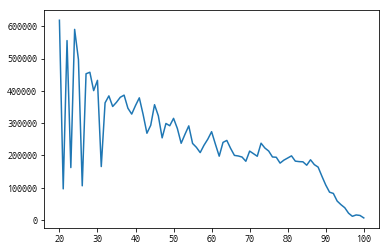

In [9]:
plt.show()

In [11]:
slot_dic

{20: 618956,
 21: 96344,
 22: 555880,
 23: 162338,
 24: 590638,
 25: 497122,
 26: 105804,
 27: 453021,
 28: 457793,
 29: 400802,
 30: 432653,
 31: 165501,
 32: 362986,
 33: 384490,
 34: 351675,
 35: 364683,
 36: 380245,
 37: 386812,
 38: 346335,
 39: 328041,
 40: 354587,
 41: 378463,
 42: 326872,
 43: 268729,
 44: 293436,
 45: 357237,
 46: 322691,
 47: 254410,
 48: 299000,
 49: 291971,
 50: 314874,
 51: 283494,
 52: 237638,
 53: 265361,
 54: 291537,
 55: 237128,
 56: 225087,
 57: 208740,
 58: 231501,
 59: 250360,
 60: 273493,
 61: 234818,
 62: 197651,
 63: 240403,
 64: 246465,
 65: 221687,
 66: 200070,
 67: 198304,
 68: 194979,
 69: 181843,
 70: 213362,
 71: 205468,
 72: 197385,
 73: 237838,
 74: 223019,
 75: 213612,
 76: 195124,
 77: 194301,
 78: 176141,
 79: 185387,
 80: 191943,
 81: 198641,
 82: 182312,
 83: 180791,
 84: 180220,
 85: 169651,
 86: 186484,
 87: 171513,
 88: 163740,
 89: 135349,
 90: 108277,
 91: 86088,
 92: 82180,
 93: 58596,
 94: 47415,
 95: 37902,
 96: 20890,
 97: 1

## ES 관련 루틴

In [5]:
es_url = '10.102.50.47:9200'
es = elasticsearch.Elasticsearch(es_url)

In [6]:
def es_gather_word2vec_with_cache(dids, w2v_cache):
    """
    dids로부터, word2vec을 모은다.
    - 모아서, average pooling 실시
    return
    - vector normalized by L2-norm
    """
    query = set()
    for did in dids:
        if did not in w2v_cache:
            query.add(did)
    
    if len(query) > 0:    
        res = es.search(index='deal_word2vec', 
                    body={
                        'from':0, 'size': len(query),
                        "_source": ["values", "v"],
                        'query': {
                            'ids': {'values': list(query) }
                            }                        
                        }
                   )
        for hit in res['hits']['hits']:
            vec = np.array(hit['_source']['values'])
            did = hit['_source']['v']
            w2v_cache[did] = [] if np.all(vec==0.0) else vec
    
    # 진짜 처리
    mat = []
    for did in dids:
        if did in w2v_cache:
            vec = w2v_cache[did]
            if len(vec) > 0:
                mat.append(vec)
    if len(mat) > 0:
        vec = np.mean(np.vstack(mat), axis=0)
        vec /= np.sqrt(np.sum(vec**2))
        return vec
    return None

### Negative Labeling 전략

-  데이터: pos_dataset_by_user.csv
- ```
sort -t, -k2,2n -k4n pos_dataset.csv > pos_dataset_by_user.csv
```

In [7]:
data_path = r'd:\WMIND\temp\pos_dataset_by_user.csv'

In [8]:
def sample_a_slot(dt, slot, reserved_slots, dic, window=10):
    """
        [slow-window, slot-1] 에서 슬롯번호 샘플링
        reserved_slots에 존재 하는 것은 제외
        dic에 존재하지 않은 슬롯은 제외시킨다.
        '만번' 이상 고르지 못하면 패스.
    """
    i = 0
    while True:
        neg_slot = np.random.randint(max(1, slot-window), slot-1)
        if neg_slot in dic and neg_slot not in reserved_slots:
            return neg_slot
        i += 1
        if i >= 10000:
            #print("=== dumps ====")
            #print(dt, slot, reserved_slots)
            #raise StopIteration
            return None


In [9]:
def do_above_sampling(u, dt, series, gte_slot):
    """
        dt 구간에 클릭된 series에 대해 pos/neg 셋을 정해준다.
        gte_slot 이상인 슬롯만 포함한다.
        100 보다 작은 슬롯 번호만 고려
    """
    pos_data = []
    neg_data = []
    dic = wepick_setting_dic[dt]
    
    reserved_slots = set(map(lambda x: x[1], series))
    for v, slot, rgtime in series:
        if slot >= gte_slot and slot < 100:
            neg_slot = sample_a_slot(dt, slot, reserved_slots, dic)
            if neg_slot is None:
                print("Error: u:{}, dt:{}, len:{}".format(u, dt, len(series)))
                break
            pos_data.append( (v, slot, rgtime) )
            neg_data.append( (dic[neg_slot][0], neg_slot, rgtime) )            
    return pos_data, neg_data


In [10]:
def get_negative_example(u, vec, wepick_setting_dic, gte_slot=20):
    """
        negative example들을 모은다.
    """
    pos_data = []
    neg_data = []
    prev_dt = None
    series = []

    for v, slot, rgtime, dt in vec:
        if prev_dt != None and prev_dt != dt:
            _pos_data, _neg_data = do_above_sampling(u, prev_dt, series, gte_slot)
            pos_data += _pos_data
            neg_data += _neg_data
            series = []
        prev_dt = dt
        series.append((v, slot, rgtime))
    if series != []:
        _pos_data, _neg_data = do_above_sampling(u, prev_dt, series, gte_slot)
        pos_data += _pos_data
        neg_data += _neg_data
    return pos_data, neg_data

In [11]:
def process_user(u, vec, wepick_setting_dic, max_profile_cnt = 24, min_profile_cnt = 4, max_sample_per_user = 24):
    """
    데이터 생성
    pos_data, neg_data를 먼저 설정한다. (딜번호 추출)
    
    user_profile 데이터 생성: 각 pos_data, neg_data의 rgtime보다 이전에 기록된 최신 max_profile_cnt 만큼을 피쳐로 사용
    
    한 유저당 최대 몇번으로 학습 데이터를 제거 해야할 필요도 있다 (아직 옵션...)
    """
    pos_data, neg_data = get_negative_example(u, vec, wepick_setting_dic)

    deal_seq = list(map(lambda x: x[0], vec))
    i, j = 0, 0
    m, n = len(vec), len(pos_data)
    data = []

    while True:
        if i == m or j == n:
            break
        if vec[i][2] < pos_data[j][2]:
            i += 1
            continue
        elif vec[i][2] > pos_data[j][2]:
            j += 1
            continue
        else:
            user_profile = deal_seq[:i]
            if len(user_profile) >= min_profile_cnt:
                data.append( (user_profile[-max_profile_cnt:], pos_data[j][0], pos_data[j][1], neg_data[j][0], neg_data[j][1], vec[i][2]) )
            i += 1
            j += 1

    if len(data) > max_sample_per_user:
        #shuffle(data)
        data = data[(-max_sample_per_user):]

    return data

In [12]:
def generate_train_data(user, data, w2v_cache, train_f, test_f):
    train_from = pd.to_datetime('2018-03-21').tz_localize('Asia/Tokyo') 
    valid_from = pd.to_datetime('2018-04-08').tz_localize('Asia/Tokyo') 
    test_from = pd.to_datetime('2018-04-11').tz_localize('Asia/Tokyo')
    for profile, p_d, ps, n_d, ns, rgtime in data:
        profile_vec = es_gather_word2vec_with_cache(profile, w2v_cache)
        pos_vec = es_gather_word2vec_with_cache([p_d], w2v_cache)
        neg_vec = es_gather_word2vec_with_cache([n_d], w2v_cache)
        if pos_vec is None or neg_vec is None or profile_vec is None:            
            continue
                    
        ts = pd.to_datetime(rgtime, unit='ms', utc=True).tz_convert('Asia/Tokyo')
        if ts < train_from:
            continue
        elif ts < valid_from:
            # train data
            pos_s = ",".join(map(lambda x: "{}".format(x), pos_vec))
            neg_s = ",".join(map(lambda x: "{}".format(x), neg_vec))
            profile_s = ",".join(map(lambda x: "{}".format(x), profile_vec))
            train_f.write("{},{},{},{},{},{},{}\n".format(user, ts, p_d, ps, 1, profile_s, pos_s))
            train_f.write("{},{},{},{},{},{},{}\n".format(user, ts, n_d, ns, 0, profile_s, neg_s))
            #print("train", user, ts, len(w2v_cache), np.sum(pos_vec**2), np.sum(neg_vec**2), np.sum(profile_vec**2))
        elif ts < test_from:
            # test data
            pos_s = ",".join(map(lambda x: "{}".format(x), pos_vec))
            neg_s = ",".join(map(lambda x: "{}".format(x), neg_vec))
            profile_s = ",".join(map(lambda x: "{}".format(x), profile_vec))
            test_f.write("{},{},{},{},{},{},{},{},{}\n".format(user, ts, p_d, ps, n_d, ns, profile_s, pos_s, neg_s))
            #print("test", user, ts, len(w2v_cache), np.sum(pos_vec**2), np.sum(neg_vec**2), np.sum(profile_vec**2))
            
        #print(":::", user, ts, len(w2v_cache), np.sum(pos_vec**2), np.sum(neg_vec**2), np.sum(profile_vec**2))
        #print(rgtime, pos_vec, neg_vec, profile_vec)
        

In [13]:
np.random.seed(0)
start = time.time()
total_time = 0
with open(r'd:\WMIND\temp\train_data_w2vec.csv', 'w') as train_f:
    with open(r'd:\WMIND\temp\test_data_w2vec.csv', 'w') as test_f:
        with open(data_path) as csvfile:
            reader = csv.reader(csvfile)
            prev_u = None
            user_vec = []
            w2v_cache = {}
            i = 0
            for row in reader:
                #v,u,slot,rgtime,dt = row[0], row[1], row[2], pd.to_datetime(row[3], unit='ms', utc=True).tz_convert('Asia/Tokyo'), row[4]
                v,u,slot,rgtime,dt = int(row[0]), int(row[1]), int(row[2]), int(row[3]), row[4]
                if prev_u != None and prev_u != u:
                    data = process_user(prev_u, user_vec, wepick_setting_dic)
                    generate_train_data(prev_u, data, w2v_cache, train_f, test_f)
                    user_vec = []
                    i += 1
                prev_u = u
                user_vec.append((v, slot, rgtime, dt))
            if user_vec != []:
                data = process_user(prev_u, user_vec, wepick_setting_dic)
                generate_train_data(prev_u, data, w2v_cache, train_f, test_f)

total_time += (time.time() - start)
print("Elapsed Time {} sec".format(total_time))                

Error: u:1091959, dt:2018-04-06 13, len:53
Error: u:1164647, dt:2018-03-23 21, len:25
Error: u:1164647, dt:2018-03-30 09, len:39
Error: u:1572472, dt:2018-04-11 19, len:70
Error: u:1839749, dt:2018-04-09 00, len:55
Error: u:2301955, dt:2018-03-28 16, len:91
Error: u:2401044, dt:2018-04-11 14, len:17
Error: u:3012680, dt:2018-04-10 12, len:51
Error: u:3332539, dt:2018-04-10 01, len:43
Error: u:4919183, dt:2018-04-11 02, len:35
Error: u:5080359, dt:2018-04-06 04, len:3
Error: u:5099826, dt:2018-04-06 22, len:18
Error: u:5171307, dt:2018-04-06 01, len:43
Error: u:6357069, dt:2018-04-11 00, len:56
Error: u:6999658, dt:2018-04-06 12, len:19
Error: u:7466302, dt:2018-04-11 18, len:31
Error: u:12769537, dt:2018-03-24 17, len:19
Error: u:12769537, dt:2018-04-02 18, len:55
Error: u:12769537, dt:2018-04-11 15, len:37
Error: u:13211197, dt:2018-03-18 17, len:44
Error: u:16342726, dt:2018-03-27 18, len:19
Error: u:19326397, dt:2018-04-11 17, len:42
Elapsed Time 7702.853108167648 sec


## 특정일 위픽 판에 대한 테스트 준비

In [29]:
for_predict_dt = '2018-04-11 21'
test_wepicks = wepick_setting_dic[for_predict_dt]

In [30]:
for_predict_dids = []
w2v_cache = {}
mat = []
for_predict_wepick_data = None
for slot, deal_infos  in test_wepicks.items():
    if slot >= 20 and slot < 100:
        deal_feature = es_gather_word2vec_with_cache([deal_infos[0]], w2v_cache)
        if deal_feature is not None:
            mat.append(np.array(deal_feature, dtype=np.float32))
            for_predict_dids.append((slot, deal_infos[0]))
        else:
            print(slot, deal_infos[0])
for_predict_wepick_data = np.vstack(mat)


In [31]:
with open('for_predict_w2v_dataset.pkl', 'wb') as f:
    pickle.dump(for_predict_wepick_data, f, pickle.HIGHEST_PROTOCOL)
    pickle.dump(for_predict_dids, f, pickle.HIGHEST_PROTOCOL)
    pickle.dump(for_predict_dt, f, pickle.HIGHEST_PROTOCOL)

In [167]:
# ms 단위 timestamp 처리
#pd.to_datetime('1520769276608', unit='ms', utc=True).tz_convert('Asia/Tokyo')

In [198]:
pd.to_datetime('1523400974328', unit='ms', utc=True).tz_convert('Asia/Tokyo')

Timestamp('2018-04-11 07:56:14.328000+0900', tz='Asia/Tokyo')

In [203]:
pd.to_datetime('2018-04-11').tz_localize('Asia/Tokyo')

Timestamp('2018-04-11 00:00:00+0900', tz='Asia/Tokyo')

In [206]:
pd.Timestamp('2018-04-11 07:56:14.328000+0900',tz='Asia/Tokyo')

Timestamp('2018-04-11 07:56:14.328000+0900', tz='Asia/Tokyo')

In [47]:
a = np.array([])

In [48]:
a

array([], dtype=float64)

In [49]:
np.all([]==0.0)

False